In this sheet I will apply Convolutional Neural Networks for stock prediction of S&P500 index. I will divide data from last 20 years into chunks. Every day contains four values: opening, low, high and closing ones - therefore input data for 30-day chunk has size 30x4. Predicted output has two classes: whether stock will go up or down or stay constant X days after last input.

In [1]:
OBSERVATION_TIME = 60
PREDICTION_AFTER_DAYS = 5
EPOCHS = 300
TEST_SIZE = 0.1
RANDOM_SPLIT = True
NORMALIZED_CHUNKS = True

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

Parameter RANDOM_SPLIT is responsible for that feature. If True, then data set is split randomly into train/test set (network knows sets from the future). When False, then split is chronological - network works like in real world.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/AAPL.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-05-18,5.064286,5.365714,4.998571,5.120000,4.432371,159180700
1,2005-05-19,5.111429,5.382857,5.111429,5.364286,4.643848,198290400
2,2005-05-20,5.321429,5.378572,5.312857,5.364286,4.643848,113162700
3,2005-05-23,5.407143,5.700000,5.407143,5.680000,4.917161,260643600
4,2005-05-24,5.635714,5.712857,5.575714,5.671429,4.909742,148365000


In [3]:
# PREPROCESSING

def percentage_to_label(percentage_value):
    return 0 if percentage_value < 0 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

In [4]:
observed_chunks[0]

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2005-05-18,5.064286,5.365714,4.998571,5.120000,4.432371,159180700
1,1,2005-05-19,5.111429,5.382857,5.111429,5.364286,4.643848,198290400
2,2,2005-05-20,5.321429,5.378572,5.312857,5.364286,4.643848,113162700
3,3,2005-05-23,5.407143,5.700000,5.407143,5.680000,4.917161,260643600
4,4,2005-05-24,5.635714,5.712857,5.575714,5.671429,4.909742,148365000
5,5,2005-05-25,5.642857,5.707143,5.617143,5.682857,4.919635,99001700
6,6,2005-05-26,5.705714,5.848571,5.705714,5.820000,5.038360,131380200
7,7,2005-05-27,5.805714,5.827143,5.715714,5.794286,5.016098,79002000
8,8,2005-05-31,5.808571,5.820000,5.654286,5.680000,4.917161,101051300
9,9,2005-06-01,5.698571,5.822857,5.694286,5.757143,4.983943,113453200


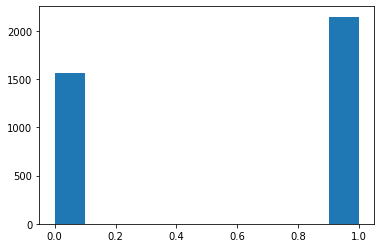

1    2148
0    1562
dtype: int64

In [5]:
import matplotlib.pyplot as plt

plt.hist(observation_results)
plt.show()

pd.Series(observation_results).value_counts()

In [6]:
# NORMALIZATION

def normalize_chunk(chunk):
    df = chunk.copy()
    for label_to_normalize in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
        np_arr = df[label_to_normalize].to_numpy()
        df[label_to_normalize] = pd.Series((np.array(np_arr) - np.mean(np_arr)) / np.std(np_arr))
    return df

def normalize_chunks(chunks):
    return list(map(lambda x: normalize_chunk(x), chunks))

observed_chunks = normalize_chunks(observed_chunks) if NORMALIZED_CHUNKS else observed_chunks

In [7]:
# TRAIN TEST SPLIT

from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[['Open', 'High', 'Low', 'Close', 'Adj Close']].to_numpy(), observed_chunks)))
Y = np.array(observation_results).astype('float32')

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3339, 60, 5), (3339,), (371, 60, 5), (371,))

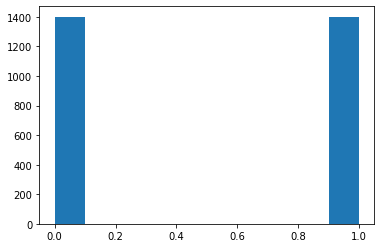

1.0    1401
0.0    1401
dtype: int64

In [8]:
# UNDERSAMPLING TRAINING SET

import random

def undersample_and_shuffle(X, Y):
    count_class_1, count_class_0 = pd.Series(Y).value_counts()

    lower_count = count_class_0 if count_class_0 < count_class_1 else count_class_1
    lower_class = 0 if count_class_0 < count_class_1 else 1
    
    diff = abs(count_class_0 - count_class_1)
    
    vec0 = random.sample([(x, y) for x, y in zip(X, Y) if y == 0], lower_count)
    vec1 = random.sample([(x, y) for x, y in zip(X, Y) if y == 1], lower_count)

    
    vec = vec0 + vec1
    random.shuffle(vec)
    return np.array(list(map(lambda x: x[0], vec))), np.array(list(map(lambda x: x[1], vec)))
    
X_train_balanced, Y_train_balanced = undersample_and_shuffle(X_train, Y_train)

plt.hist(Y_train_balanced)
plt.show()

pd.Series(Y_train_balanced).value_counts()

In [9]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (OBSERVATION_TIME, 5), filters=16, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 60, 16)            416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 16)            64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 8)             648       
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 8)             32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, 8)            

In [10]:
from keras.optimizers import Nadam
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=METRICS)

In [11]:

history = model.fit(x=X_train_balanced, 
                    y=Y_train_balanced, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True)

model.save("model-binary.h5")
model.save_weights('model-binry-weights.h5')

Train on 2802 samples, validate on 371 samples
Epoch 1/300
2802/2802 [==============================] - 1s 305us/step - loss: 0.7838 - tp: 668.0000 - fp: 686.0000 - tn: 715.0000 - fn: 733.0000 - accuracy: 0.4936 - precision: 0.4934 - recall: 0.4768 - auc: 0.4907 - val_loss: 0.7305 - val_tp: 6.0000 - val_fp: 3.0000 - val_tn: 158.0000 - val_fn: 204.0000 - val_accuracy: 0.4420 - val_precision: 0.6667 - val_recall: 0.0286 - val_auc: 0.5841
Epoch 2/300
2802/2802 [==============================] - 0s 74us/step - loss: 0.7318 - tp: 717.0000 - fp: 669.0000 - tn: 732.0000 - fn: 684.0000 - accuracy: 0.5171 - precision: 0.5173 - recall: 0.5118 - auc: 0.5264 - val_loss: 0.6990 - val_tp: 52.0000 - val_fp: 25.0000 - val_tn: 136.0000 - val_fn: 158.0000 - val_accuracy: 0.5067 - val_precision: 0.6753 - val_recall: 0.2476 - val_auc: 0.5849
Epoch 3/300
2802/2802 [==============================] - 0s 73us/step - loss: 0.7135 - tp: 735.0000 - fp: 675.0000 - tn: 726.0000 - fn: 666.0000 - accuracy: 0.5214 - 

Epoch 22/300
2802/2802 [==============================] - 0s 66us/step - loss: 0.6790 - tp: 817.0000 - fp: 651.0000 - tn: 750.0000 - fn: 584.0000 - accuracy: 0.5592 - precision: 0.5565 - recall: 0.5832 - auc: 0.5967 - val_loss: 0.6708 - val_tp: 127.0000 - val_fp: 70.0000 - val_tn: 91.0000 - val_fn: 83.0000 - val_accuracy: 0.5876 - val_precision: 0.6447 - val_recall: 0.6048 - val_auc: 0.6250
Epoch 23/300
2802/2802 [==============================] - 0s 70us/step - loss: 0.6757 - tp: 808.0000 - fp: 617.0000 - tn: 784.0000 - fn: 593.0000 - accuracy: 0.5682 - precision: 0.5670 - recall: 0.5767 - auc: 0.6040 - val_loss: 0.6708 - val_tp: 135.0000 - val_fp: 68.0000 - val_tn: 93.0000 - val_fn: 75.0000 - val_accuracy: 0.6146 - val_precision: 0.6650 - val_recall: 0.6429 - val_auc: 0.6269
Epoch 24/300
2802/2802 [==============================] - 0s 68us/step - loss: 0.6656 - tp: 845.0000 - fp: 600.0000 - tn: 801.0000 - fn: 556.0000 - accuracy: 0.5874 - precision: 0.5848 - recall: 0.6031 - auc: 0.6

Epoch 43/300
2802/2802 [==============================] - 0s 69us/step - loss: 0.6451 - tp: 903.0000 - fp: 523.0000 - tn: 878.0000 - fn: 498.0000 - accuracy: 0.6356 - precision: 0.6332 - recall: 0.6445 - auc: 0.6748 - val_loss: 0.6600 - val_tp: 145.0000 - val_fp: 74.0000 - val_tn: 87.0000 - val_fn: 65.0000 - val_accuracy: 0.6253 - val_precision: 0.6621 - val_recall: 0.6905 - val_auc: 0.6469
Epoch 44/300
2802/2802 [==============================] - 0s 67us/step - loss: 0.6541 - tp: 878.0000 - fp: 556.0000 - tn: 845.0000 - fn: 523.0000 - accuracy: 0.6149 - precision: 0.6123 - recall: 0.6267 - auc: 0.6568 - val_loss: 0.6632 - val_tp: 121.0000 - val_fp: 56.0000 - val_tn: 105.0000 - val_fn: 89.0000 - val_accuracy: 0.6092 - val_precision: 0.6836 - val_recall: 0.5762 - val_auc: 0.6566
Epoch 45/300
2802/2802 [==============================] - 0s 66us/step - loss: 0.6520 - tp: 856.0000 - fp: 540.0000 - tn: 861.0000 - fn: 545.0000 - accuracy: 0.6128 - precision: 0.6132 - recall: 0.6110 - auc: 0.

Epoch 64/300
2802/2802 [==============================] - 0s 67us/step - loss: 0.6289 - tp: 868.0000 - fp: 519.0000 - tn: 882.0000 - fn: 533.0000 - accuracy: 0.6246 - precision: 0.6258 - recall: 0.6196 - auc: 0.6902 - val_loss: 0.6407 - val_tp: 154.0000 - val_fp: 73.0000 - val_tn: 88.0000 - val_fn: 56.0000 - val_accuracy: 0.6523 - val_precision: 0.6784 - val_recall: 0.7333 - val_auc: 0.6744
Epoch 65/300
2802/2802 [==============================] - 0s 66us/step - loss: 0.6414 - tp: 903.0000 - fp: 542.0000 - tn: 859.0000 - fn: 498.0000 - accuracy: 0.6288 - precision: 0.6249 - recall: 0.6445 - auc: 0.6755 - val_loss: 0.6429 - val_tp: 147.0000 - val_fp: 69.0000 - val_tn: 92.0000 - val_fn: 63.0000 - val_accuracy: 0.6442 - val_precision: 0.6806 - val_recall: 0.7000 - val_auc: 0.6738
Epoch 66/300
2802/2802 [==============================] - 0s 68us/step - loss: 0.6285 - tp: 883.0000 - fp: 510.0000 - tn: 891.0000 - fn: 518.0000 - accuracy: 0.6331 - precision: 0.6339 - recall: 0.6303 - auc: 0.6

Epoch 85/300
2802/2802 [==============================] - 0s 72us/step - loss: 0.6060 - tp: 938.0000 - fp: 478.0000 - tn: 923.0000 - fn: 463.0000 - accuracy: 0.6642 - precision: 0.6624 - recall: 0.6695 - auc: 0.7318 - val_loss: 0.6556 - val_tp: 122.0000 - val_fp: 43.0000 - val_tn: 118.0000 - val_fn: 88.0000 - val_accuracy: 0.6469 - val_precision: 0.7394 - val_recall: 0.5810 - val_auc: 0.6788
Epoch 86/300
2802/2802 [==============================] - 0s 71us/step - loss: 0.6109 - tp: 956.0000 - fp: 509.0000 - tn: 892.0000 - fn: 445.0000 - accuracy: 0.6595 - precision: 0.6526 - recall: 0.6824 - auc: 0.7235 - val_loss: 0.6497 - val_tp: 124.0000 - val_fp: 45.0000 - val_tn: 116.0000 - val_fn: 86.0000 - val_accuracy: 0.6469 - val_precision: 0.7337 - val_recall: 0.5905 - val_auc: 0.6867
Epoch 87/300
2802/2802 [==============================] - 0s 71us/step - loss: 0.6020 - tp: 946.0000 - fp: 477.0000 - tn: 924.0000 - fn: 455.0000 - accuracy: 0.6674 - precision: 0.6648 - recall: 0.6752 - auc: 0

Epoch 106/300
2802/2802 [==============================] - 0s 72us/step - loss: 0.5787 - tp: 1001.0000 - fp: 447.0000 - tn: 954.0000 - fn: 400.0000 - accuracy: 0.6977 - precision: 0.6913 - recall: 0.7145 - auc: 0.7648 - val_loss: 0.6483 - val_tp: 129.0000 - val_fp: 52.0000 - val_tn: 109.0000 - val_fn: 81.0000 - val_accuracy: 0.6415 - val_precision: 0.7127 - val_recall: 0.6143 - val_auc: 0.6745
Epoch 107/300
2802/2802 [==============================] - 0s 71us/step - loss: 0.5827 - tp: 962.0000 - fp: 442.0000 - tn: 959.0000 - fn: 439.0000 - accuracy: 0.6856 - precision: 0.6852 - recall: 0.6867 - auc: 0.7594 - val_loss: 0.6340 - val_tp: 142.0000 - val_fp: 57.0000 - val_tn: 104.0000 - val_fn: 68.0000 - val_accuracy: 0.6631 - val_precision: 0.7136 - val_recall: 0.6762 - val_auc: 0.6982
Epoch 108/300
2802/2802 [==============================] - 0s 73us/step - loss: 0.5837 - tp: 959.0000 - fp: 444.0000 - tn: 957.0000 - fn: 442.0000 - accuracy: 0.6838 - precision: 0.6835 - recall: 0.6845 - au

Epoch 127/300
2802/2802 [==============================] - 0s 70us/step - loss: 0.5728 - tp: 1008.0000 - fp: 443.0000 - tn: 958.0000 - fn: 393.0000 - accuracy: 0.7016 - precision: 0.6947 - recall: 0.7195 - auc: 0.7686 - val_loss: 0.6460 - val_tp: 132.0000 - val_fp: 48.0000 - val_tn: 113.0000 - val_fn: 78.0000 - val_accuracy: 0.6604 - val_precision: 0.7333 - val_recall: 0.6286 - val_auc: 0.6923
Epoch 128/300
2802/2802 [==============================] - 0s 67us/step - loss: 0.5599 - tp: 1001.0000 - fp: 391.0000 - tn: 1010.0000 - fn: 400.0000 - accuracy: 0.7177 - precision: 0.7191 - recall: 0.7145 - auc: 0.7853 - val_loss: 0.6421 - val_tp: 135.0000 - val_fp: 52.0000 - val_tn: 109.0000 - val_fn: 75.0000 - val_accuracy: 0.6577 - val_precision: 0.7219 - val_recall: 0.6429 - val_auc: 0.6985
Epoch 129/300
2802/2802 [==============================] - 0s 69us/step - loss: 0.5562 - tp: 1003.0000 - fp: 442.0000 - tn: 959.0000 - fn: 398.0000 - accuracy: 0.7002 - precision: 0.6941 - recall: 0.7159 -

Epoch 148/300
2802/2802 [==============================] - 0s 71us/step - loss: 0.5376 - tp: 1035.0000 - fp: 411.0000 - tn: 990.0000 - fn: 366.0000 - accuracy: 0.7227 - precision: 0.7158 - recall: 0.7388 - auc: 0.8044 - val_loss: 0.6610 - val_tp: 127.0000 - val_fp: 46.0000 - val_tn: 115.0000 - val_fn: 83.0000 - val_accuracy: 0.6523 - val_precision: 0.7341 - val_recall: 0.6048 - val_auc: 0.6825
Epoch 149/300
2802/2802 [==============================] - 0s 70us/step - loss: 0.5513 - tp: 1021.0000 - fp: 415.0000 - tn: 986.0000 - fn: 380.0000 - accuracy: 0.7163 - precision: 0.7110 - recall: 0.7288 - auc: 0.7914 - val_loss: 0.6491 - val_tp: 128.0000 - val_fp: 48.0000 - val_tn: 113.0000 - val_fn: 82.0000 - val_accuracy: 0.6496 - val_precision: 0.7273 - val_recall: 0.6095 - val_auc: 0.6922
Epoch 150/300
2802/2802 [==============================] - 0s 71us/step - loss: 0.5521 - tp: 1009.0000 - fp: 424.0000 - tn: 977.0000 - fn: 392.0000 - accuracy: 0.7088 - precision: 0.7041 - recall: 0.7202 - 

Epoch 169/300
2802/2802 [==============================] - 0s 67us/step - loss: 0.5320 - tp: 1017.0000 - fp: 379.0000 - tn: 1022.0000 - fn: 384.0000 - accuracy: 0.7277 - precision: 0.7285 - recall: 0.7259 - auc: 0.8082 - val_loss: 0.6392 - val_tp: 128.0000 - val_fp: 48.0000 - val_tn: 113.0000 - val_fn: 82.0000 - val_accuracy: 0.6496 - val_precision: 0.7273 - val_recall: 0.6095 - val_auc: 0.7108
Epoch 170/300
2802/2802 [==============================] - 0s 66us/step - loss: 0.5286 - tp: 1046.0000 - fp: 393.0000 - tn: 1008.0000 - fn: 355.0000 - accuracy: 0.7330 - precision: 0.7269 - recall: 0.7466 - auc: 0.8129 - val_loss: 0.6318 - val_tp: 145.0000 - val_fp: 50.0000 - val_tn: 111.0000 - val_fn: 65.0000 - val_accuracy: 0.6900 - val_precision: 0.7436 - val_recall: 0.6905 - val_auc: 0.7221
Epoch 171/300
2802/2802 [==============================] - 0s 69us/step - loss: 0.5279 - tp: 1044.0000 - fp: 378.0000 - tn: 1023.0000 - fn: 357.0000 - accuracy: 0.7377 - precision: 0.7342 - recall: 0.7452

Epoch 190/300
2802/2802 [==============================] - 0s 70us/step - loss: 0.5176 - tp: 1025.0000 - fp: 368.0000 - tn: 1033.0000 - fn: 376.0000 - accuracy: 0.7345 - precision: 0.7358 - recall: 0.7316 - auc: 0.8202 - val_loss: 0.6388 - val_tp: 136.0000 - val_fp: 51.0000 - val_tn: 110.0000 - val_fn: 74.0000 - val_accuracy: 0.6631 - val_precision: 0.7273 - val_recall: 0.6476 - val_auc: 0.7123
Epoch 191/300
2802/2802 [==============================] - 0s 71us/step - loss: 0.5222 - tp: 1052.0000 - fp: 414.0000 - tn: 987.0000 - fn: 349.0000 - accuracy: 0.7277 - precision: 0.7176 - recall: 0.7509 - auc: 0.8143 - val_loss: 0.6501 - val_tp: 121.0000 - val_fp: 42.0000 - val_tn: 119.0000 - val_fn: 89.0000 - val_accuracy: 0.6469 - val_precision: 0.7423 - val_recall: 0.5762 - val_auc: 0.7066
Epoch 192/300
2802/2802 [==============================] - 0s 69us/step - loss: 0.5160 - tp: 1041.0000 - fp: 372.0000 - tn: 1029.0000 - fn: 360.0000 - accuracy: 0.7388 - precision: 0.7367 - recall: 0.7430 

Epoch 211/300
2802/2802 [==============================] - 0s 70us/step - loss: 0.5075 - tp: 1067.0000 - fp: 383.0000 - tn: 1018.0000 - fn: 334.0000 - accuracy: 0.7441 - precision: 0.7359 - recall: 0.7616 - auc: 0.8276 - val_loss: 0.6466 - val_tp: 131.0000 - val_fp: 45.0000 - val_tn: 116.0000 - val_fn: 79.0000 - val_accuracy: 0.6658 - val_precision: 0.7443 - val_recall: 0.6238 - val_auc: 0.7101
Epoch 212/300
2802/2802 [==============================] - 0s 69us/step - loss: 0.4982 - tp: 1047.0000 - fp: 334.0000 - tn: 1067.0000 - fn: 354.0000 - accuracy: 0.7545 - precision: 0.7581 - recall: 0.7473 - auc: 0.8373 - val_loss: 0.6481 - val_tp: 142.0000 - val_fp: 52.0000 - val_tn: 109.0000 - val_fn: 68.0000 - val_accuracy: 0.6765 - val_precision: 0.7320 - val_recall: 0.6762 - val_auc: 0.7134
Epoch 213/300
2802/2802 [==============================] - 0s 68us/step - loss: 0.5073 - tp: 1049.0000 - fp: 373.0000 - tn: 1028.0000 - fn: 352.0000 - accuracy: 0.7413 - precision: 0.7377 - recall: 0.7488

Epoch 232/300
2802/2802 [==============================] - 0s 69us/step - loss: 0.4871 - tp: 1078.0000 - fp: 354.0000 - tn: 1047.0000 - fn: 323.0000 - accuracy: 0.7584 - precision: 0.7528 - recall: 0.7695 - auc: 0.8431 - val_loss: 0.6494 - val_tp: 128.0000 - val_fp: 44.0000 - val_tn: 117.0000 - val_fn: 82.0000 - val_accuracy: 0.6604 - val_precision: 0.7442 - val_recall: 0.6095 - val_auc: 0.7172
Epoch 233/300
2802/2802 [==============================] - 0s 69us/step - loss: 0.4914 - tp: 1049.0000 - fp: 344.0000 - tn: 1057.0000 - fn: 352.0000 - accuracy: 0.7516 - precision: 0.7531 - recall: 0.7488 - auc: 0.8407 - val_loss: 0.6646 - val_tp: 131.0000 - val_fp: 49.0000 - val_tn: 112.0000 - val_fn: 79.0000 - val_accuracy: 0.6550 - val_precision: 0.7278 - val_recall: 0.6238 - val_auc: 0.7055
Epoch 234/300
2802/2802 [==============================] - 0s 70us/step - loss: 0.4919 - tp: 1093.0000 - fp: 359.0000 - tn: 1042.0000 - fn: 308.0000 - accuracy: 0.7620 - precision: 0.7528 - recall: 0.7802

Epoch 253/300
2802/2802 [==============================] - 0s 70us/step - loss: 0.4747 - tp: 1076.0000 - fp: 338.0000 - tn: 1063.0000 - fn: 325.0000 - accuracy: 0.7634 - precision: 0.7610 - recall: 0.7680 - auc: 0.8548 - val_loss: 0.6598 - val_tp: 121.0000 - val_fp: 37.0000 - val_tn: 124.0000 - val_fn: 89.0000 - val_accuracy: 0.6604 - val_precision: 0.7658 - val_recall: 0.5762 - val_auc: 0.7124
Epoch 254/300
2802/2802 [==============================] - 0s 69us/step - loss: 0.4744 - tp: 1079.0000 - fp: 328.0000 - tn: 1073.0000 - fn: 322.0000 - accuracy: 0.7680 - precision: 0.7669 - recall: 0.7702 - auc: 0.8548 - val_loss: 0.6444 - val_tp: 139.0000 - val_fp: 55.0000 - val_tn: 106.0000 - val_fn: 71.0000 - val_accuracy: 0.6604 - val_precision: 0.7165 - val_recall: 0.6619 - val_auc: 0.7153
Epoch 255/300
2802/2802 [==============================] - 0s 67us/step - loss: 0.4784 - tp: 1055.0000 - fp: 332.0000 - tn: 1069.0000 - fn: 346.0000 - accuracy: 0.7580 - precision: 0.7606 - recall: 0.7530

Epoch 274/300
2802/2802 [==============================] - 0s 70us/step - loss: 0.4587 - tp: 1111.0000 - fp: 332.0000 - tn: 1069.0000 - fn: 290.0000 - accuracy: 0.7780 - precision: 0.7699 - recall: 0.7930 - auc: 0.8656 - val_loss: 0.6570 - val_tp: 121.0000 - val_fp: 42.0000 - val_tn: 119.0000 - val_fn: 89.0000 - val_accuracy: 0.6469 - val_precision: 0.7423 - val_recall: 0.5762 - val_auc: 0.7258
Epoch 275/300
2802/2802 [==============================] - 0s 69us/step - loss: 0.4638 - tp: 1079.0000 - fp: 315.0000 - tn: 1086.0000 - fn: 322.0000 - accuracy: 0.7727 - precision: 0.7740 - recall: 0.7702 - auc: 0.8621 - val_loss: 0.6485 - val_tp: 130.0000 - val_fp: 39.0000 - val_tn: 122.0000 - val_fn: 80.0000 - val_accuracy: 0.6792 - val_precision: 0.7692 - val_recall: 0.6190 - val_auc: 0.7281
Epoch 276/300
2802/2802 [==============================] - 0s 70us/step - loss: 0.4615 - tp: 1117.0000 - fp: 346.0000 - tn: 1055.0000 - fn: 284.0000 - accuracy: 0.7752 - precision: 0.7635 - recall: 0.7973

Epoch 295/300
2802/2802 [==============================] - 0s 71us/step - loss: 0.4524 - tp: 1075.0000 - fp: 312.0000 - tn: 1089.0000 - fn: 326.0000 - accuracy: 0.7723 - precision: 0.7751 - recall: 0.7673 - auc: 0.8673 - val_loss: 0.6609 - val_tp: 133.0000 - val_fp: 47.0000 - val_tn: 114.0000 - val_fn: 77.0000 - val_accuracy: 0.6658 - val_precision: 0.7389 - val_recall: 0.6333 - val_auc: 0.7118
Epoch 296/300
2802/2802 [==============================] - 0s 70us/step - loss: 0.4472 - tp: 1102.0000 - fp: 306.0000 - tn: 1095.0000 - fn: 299.0000 - accuracy: 0.7841 - precision: 0.7827 - recall: 0.7866 - auc: 0.8731 - val_loss: 0.6456 - val_tp: 146.0000 - val_fp: 54.0000 - val_tn: 107.0000 - val_fn: 64.0000 - val_accuracy: 0.6819 - val_precision: 0.7300 - val_recall: 0.6952 - val_auc: 0.7251
Epoch 297/300
2802/2802 [==============================] - 0s 69us/step - loss: 0.4585 - tp: 1089.0000 - fp: 313.0000 - tn: 1088.0000 - fn: 312.0000 - accuracy: 0.7769 - precision: 0.7767 - recall: 0.7773

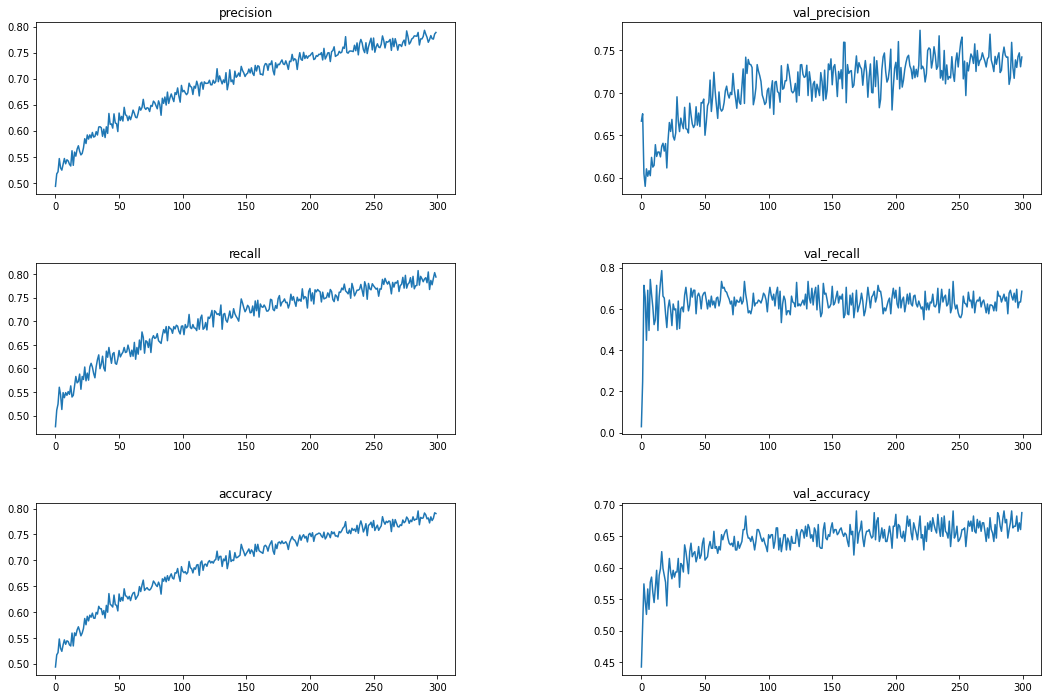

In [12]:
history_dict = history.history
history_dict.keys()

plotted_metrics = ['precision', 'recall', 'accuracy']

fig = plt.figure(figsize=(18, 4 * len(plotted_metrics)))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for idx, metric in enumerate(plotted_metrics):
    plt.subplot(len(plotted_metrics), 2, 2*idx+1)
    plt.title(metric)
    plt.plot(history_dict[metric])
    
    plt.subplot(len(plotted_metrics), 2, 2*idx+2)
    plt.title('val_{}'.format(metric))
    plt.plot(history_dict['val_{}'.format(metric)])

plt.show()

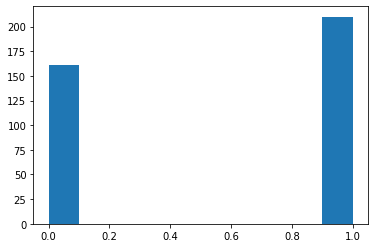

1.0    210
0.0    161
dtype: int64

In [13]:
plt.hist(Y_test)
plt.show()

pd.Series(Y_test).value_counts()

**FEATURE VISUALIZATION** Now, as the model is ready, lets try to explain it a little.

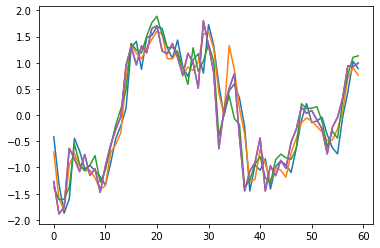

In [32]:
def plot_sample(sample):
    for idx, label in enumerate(['Open', 'High', 'Low', 'Close', 'Adj Close']):
        plt.plot(sample[:, idx])

plot_sample(X_test[2])

In [40]:
from keras.models import Model

model_viz = Model(inputs=model.inputs, outputs=model.layers[0].output)
model_viz.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1_input (InputLayer)  (None, 60, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60, 16)            416       
Total params: 416
Trainable params: 416
Non-trainable params: 0
_________________________________________________________________


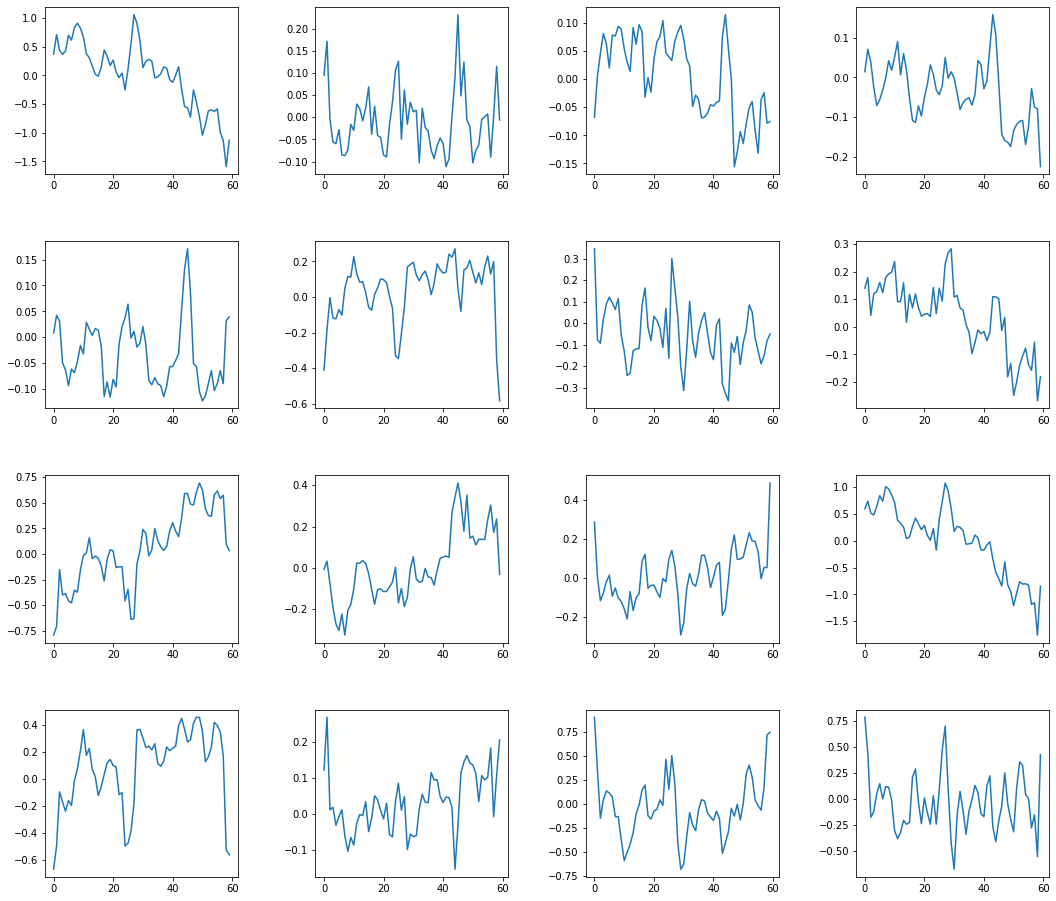

In [57]:
prediction = model_viz.predict(np.array([X_test[0]]))

square = 4
idx = 1

fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, idx)
        plt.plot(prediction[:,:,idx-1][0])
        idx += 1

plt.show()